In [1]:
import sys
sys.path.insert(1, '/t0-analysis/CKA-similarity')

import numpy as np
from CKA import CKA

import matplotlib
import matplotlib.pyplot as plt

from utils import load_hidden_representations_from_hdf5, read_templates_from_file

In [2]:
# params
log_dir = "/logfiles"
model = "bigscience-T0_3B" # bigscience-T0_B or bigscience-T0
module = "encoder" # encoder or decoder
# task = "rte"
task = "cb"
# task = "wic"

## Prompts

In [3]:
df = read_templates_from_file(f"/t0-analysis/prompts/{task}.csv")
display(df)

,name,template,category,includes_labels,shuffle
0,null_pattern,{premise} {hypothesis},neutral,False,False
1,null_pattern_reversed,{hypothesis} {premise},neutral,False,False
2,gpt_3_true_false_neither,"{premise} Question: {hypothesis} True, False, ...",instructive,True,False
3,gpt_3_yes_no_maybe,"{premise} Question: {hypothesis} Yes, No, or M...",instructive,True,False
4,mnli_crowdsource,{premise} Using only the above description and...,instructive,True,False
5,always_sometimes_never,"Suppose it's true that {premise} Then, is ""{hy...",instructive,True,False
6,based_on_previous_passage,"{premise} Based on the previous passage, is it...",instructive,True,False
7,infer,"Suppose {premise} Can we infer that ""{hypothes...",instructive,True,False
8,claim,"{premise} Based on that information, is the cl...",instructive,True,False
9,consider,"{premise} Keeping in mind the above text, cons...",instructive,True,False


## Comput CKA

In [4]:
# RTE patterns
# use_pattern = [
#     "null_pattern",
#     "null_pattern_reversed",
#     "gpt_3_yes_no",
#     "gpt_3_yes_no_shuffled",
#     "gpt_3_true_false",
#     "gpt_3_true_false_shuffled",
#     "start_with_the",
#     "mnli_crowdsource",
#     "based_on_previous_passage",
#     "infer",
#     "follow",
#     "imply",
#     "guaranteed",
#     "justified", 
#     "must_be_true",
#     "should_assume"
# ]

# CB patterns
use_pattern = [
    "null_pattern",
    "null_pattern_reversed",
    "gpt_3_true_false_neither",
    "gpt_3_yes_no_maybe",
    "mnli_crowdsource",
    "always_sometimes_never",
    "based_on_previous_passage",
    "infer",
    "claim",
    "consider",
    "follow",
    "imply",
    "guaranteed",
    "guaranteed_possible",
    "justified",
    "must_be_true",
    "should_assume",
    "take_the_following",
]

# WIC patterns
# use_pattern = [
#     "gpt_3",
#     "gpt_3_yes_no",
#     "affirmation",
#     "grammar_homework",
#     "polysemous",
#     "question_context",
#     "question_meaning",
#     "question_meaning_yes_no",
#     "same_sense",
#     "similar_sense",
#     "similar_sense_yes_no",
# ]

In [13]:
representations = {}

# for layer in range(0, 1):
# for layer in range(0, 5):
for layer in range(0, 25):
# for layer in range(24, 25):
    
    file_names, prompt_names = [], []

    layer_key = f"{module}-{layer}"
    if layer_key not in representations:
        representations[layer_key] = {}
    
    for _, row in df.iterrows():
        if row['name'] in use_pattern:
            file_name = f"{task}/{model}/{module}/{row['name']}/hidden_represenations_layer{layer}_avg.hdf5"
            file_names.append(file_name)
            prompt_names.append(row['name'])
            if file_name not in representations[layer_key]:
                # load hidden representations from hdf5 file
                representations[layer_key][file_name] = load_hidden_representations_from_hdf5(os.path.join(log_dir, file_name), silent=True)
    
    

In [14]:
representations["encoder-0"].keys()

dict_keys(['cb/bigscience-T0_3B/encoder/null_pattern/hidden_represenations_layer0_avg.hdf5', 'cb/bigscience-T0_3B/encoder/null_pattern_reversed/hidden_represenations_layer0_avg.hdf5', 'cb/bigscience-T0_3B/encoder/gpt_3_true_false_neither/hidden_represenations_layer0_avg.hdf5', 'cb/bigscience-T0_3B/encoder/gpt_3_yes_no_maybe/hidden_represenations_layer0_avg.hdf5', 'cb/bigscience-T0_3B/encoder/mnli_crowdsource/hidden_represenations_layer0_avg.hdf5', 'cb/bigscience-T0_3B/encoder/always_sometimes_never/hidden_represenations_layer0_avg.hdf5', 'cb/bigscience-T0_3B/encoder/based_on_previous_passage/hidden_represenations_layer0_avg.hdf5', 'cb/bigscience-T0_3B/encoder/infer/hidden_represenations_layer0_avg.hdf5', 'cb/bigscience-T0_3B/encoder/claim/hidden_represenations_layer0_avg.hdf5', 'cb/bigscience-T0_3B/encoder/consider/hidden_represenations_layer0_avg.hdf5', 'cb/bigscience-T0_3B/encoder/follow/hidden_represenations_layer0_avg.hdf5', 'cb/bigscience-T0_3B/encoder/imply/hidden_represenations_

In [15]:
len(representations["encoder-0"].keys())

18

In [16]:
# Compute pairwise CKA for every layer
np_cka = CKA()

cka_scores_layers = {}
for layer in list(representations.keys())[:]:
    cka_scores = []
    for pattern1 in representations[layer].keys():
        cka_scores_pattern1 = []
        for pattern2 in representations[layer].keys():
            # print(representations[layer][pattern1].shape, representations[layer][pattern2].shape)
            cka_score = np_cka.linear_CKA(representations[layer][pattern1], representations[layer][pattern2])
            cka_scores_pattern1.append(cka_score)
        cka_scores.append(cka_scores_pattern1)
    cka_scores = np.asarray(cka_scores)
    cka_scores_layers[layer] = cka_scores
    # print(cka_scores.shape)


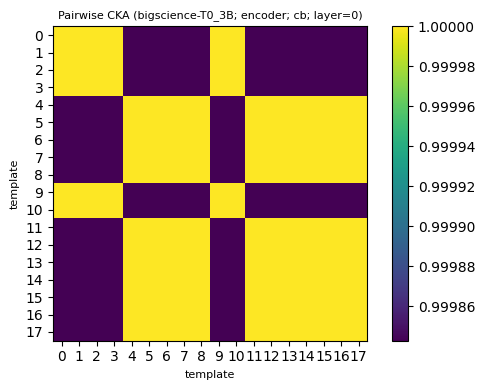

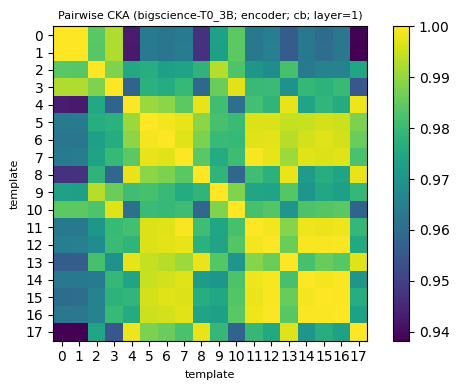

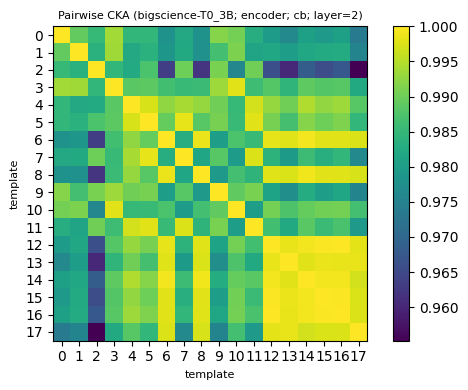

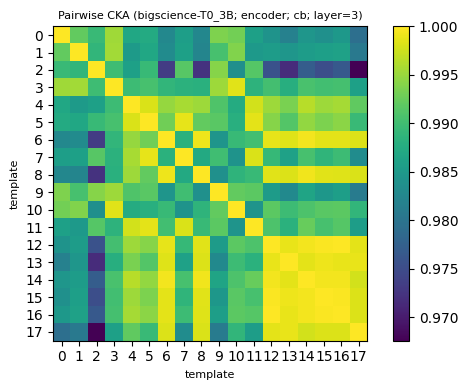

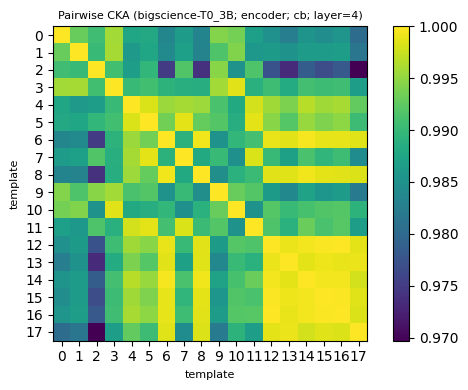

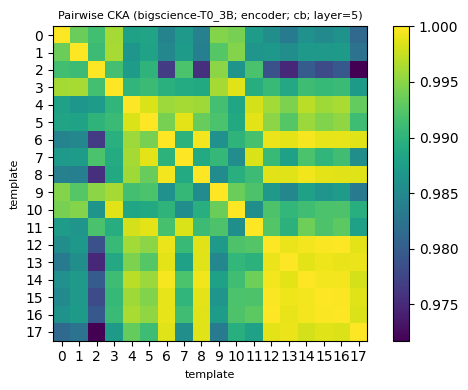

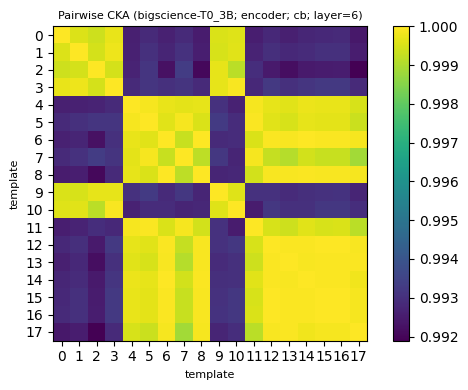

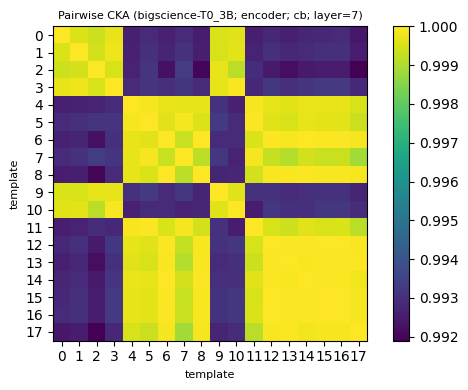

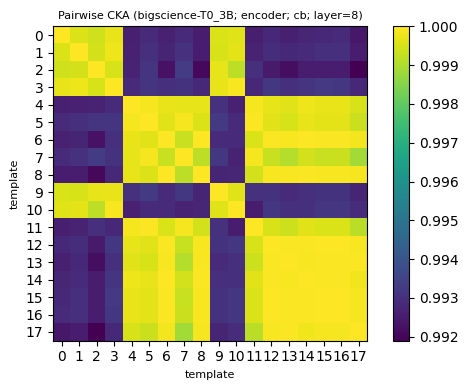

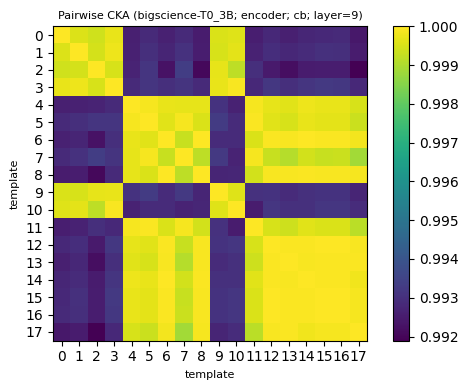

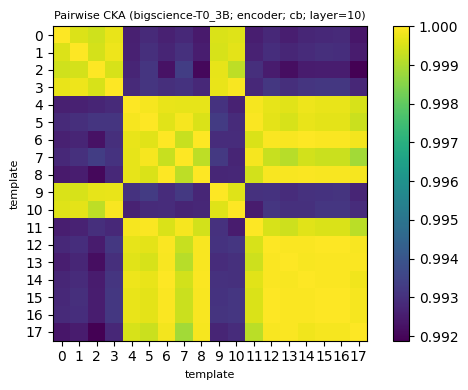

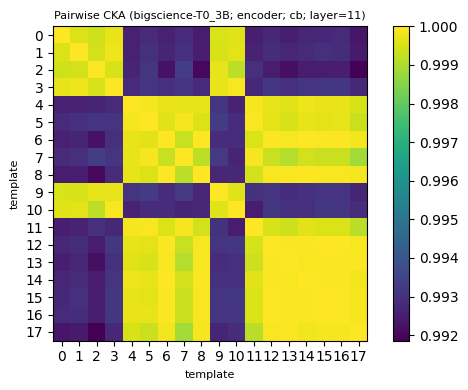

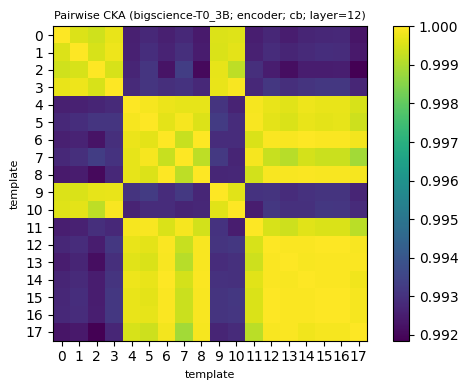

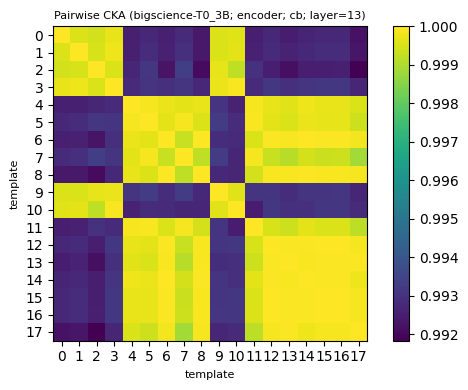

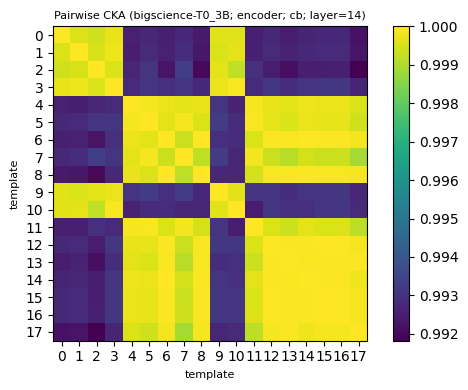

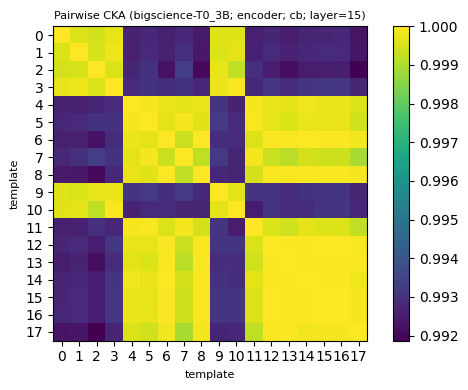

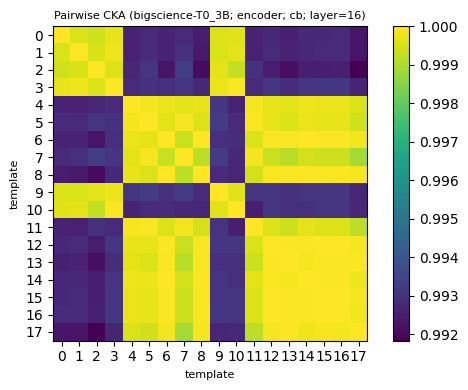

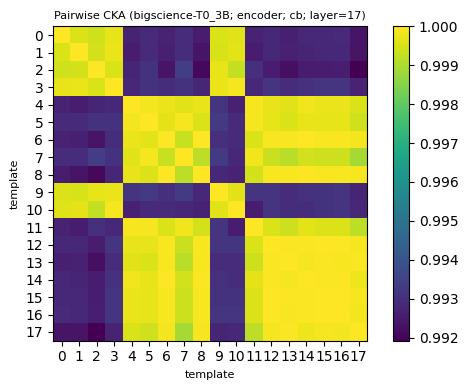

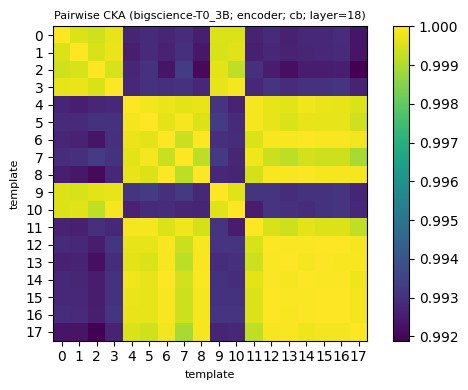

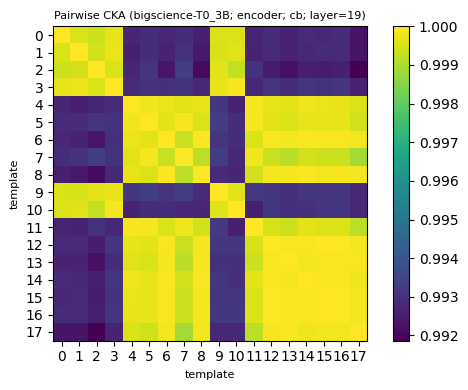

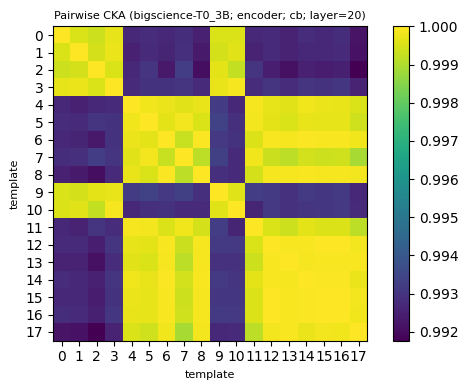

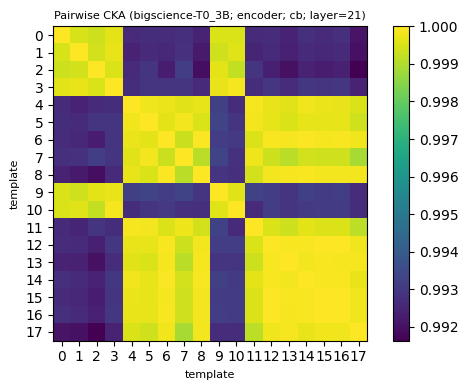

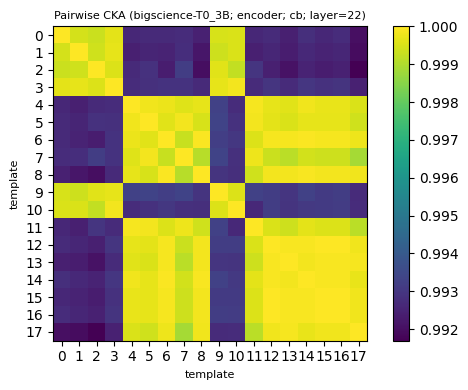

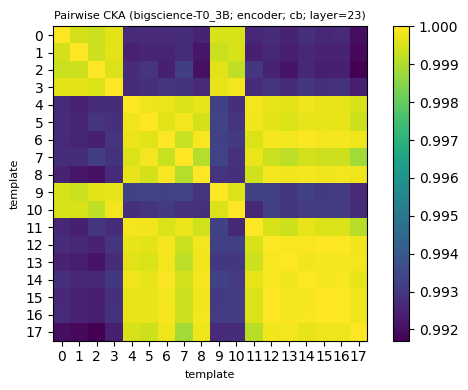

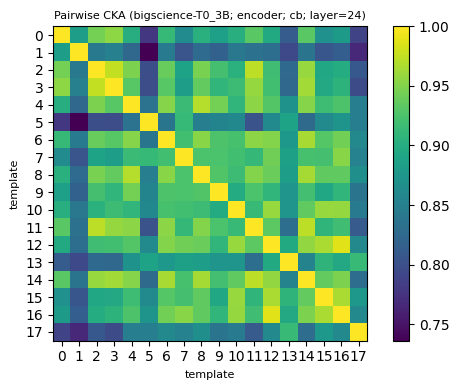

In [17]:
for layer_key in cka_scores_layers.keys():
    values = cka_scores_layers[layer_key]
    layer = layer_key.split('-')[-1]

    fig, axes = plt.subplots(1, 1, figsize=(5.5,4), dpi=100)

    im = axes.imshow(values, cmap='viridis', vmax=1.0)
    # Create colorbar
    cbar = axes.figure.colorbar(im, ax=axes)
    cbar.ax.set_ylabel("", rotation=-90, va="bottom")

    axes.set_xlabel("template", fontsize=8)
    axes.set_xticks(np.arange(len(values)))
    axes.set_ylabel("template", fontsize=8)
    axes.set_yticks(np.arange(len(values)))

    axes.set_title(f"Pairwise CKA ({model}; {module}; {task}; layer={layer})", fontsize=8)

    plt.tight_layout()
    plt.show()
    plt.close();


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


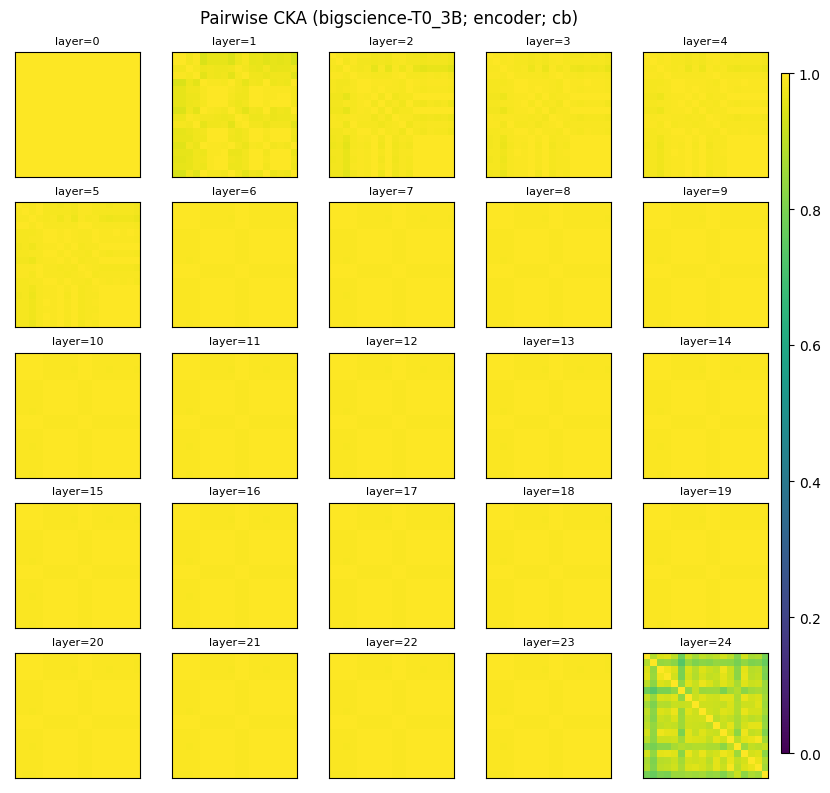

In [18]:
plt.figure(figsize=(8, 8), dpi=100)

for l, layer_key in enumerate(cka_scores_layers.keys()):
    values = cka_scores_layers[layer_key]
    layer = layer_key.split('-')[-1]

    plt.subplot(5, 5, l+1)
    axes = plt.gca()
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False)
    im = axes.imshow(values, cmap='viridis', vmin=0.0, vmax=1.0)
    # Create colorbar
    # cbar = axes.figure.colorbar(im, ax=axes)
    # cbar.ax.set_ylabel("", rotation=-90, va="bottom")

    axes.set_xlabel("template", fontsize=8)
    axes.set_xticks(np.arange(len(values)))
    axes.set_ylabel("template", fontsize=8)
    axes.set_yticks(np.arange(len(values)))

    # axes.set_title(f"Pairwise CKA ({model}; {module}; {task}; layer={layer})", fontsize=8)
    axes.set_title(f"layer={layer}", fontsize=8)

# add colorbar
fig = plt.gcf()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.99, 0.05, 0.01, 0.85])
fig.colorbar(im, cax=cbar_ax)

plt.suptitle(f"Pairwise CKA ({model}; {module}; {task})")
plt.tight_layout()
plt.show()
plt.close();

In [19]:
df

,name,template,category,includes_labels,shuffle
0,null_pattern,{premise} {hypothesis},neutral,False,False
1,null_pattern_reversed,{hypothesis} {premise},neutral,False,False
2,gpt_3_true_false_neither,"{premise} Question: {hypothesis} True, False, ...",instructive,True,False
3,gpt_3_yes_no_maybe,"{premise} Question: {hypothesis} Yes, No, or M...",instructive,True,False
4,mnli_crowdsource,{premise} Using only the above description and...,instructive,True,False
5,always_sometimes_never,"Suppose it's true that {premise} Then, is ""{hy...",instructive,True,False
6,based_on_previous_passage,"{premise} Based on the previous passage, is it...",instructive,True,False
7,infer,"Suppose {premise} Can we infer that ""{hypothes...",instructive,True,False
8,claim,"{premise} Based on that information, is the cl...",instructive,True,False
9,consider,"{premise} Keeping in mind the above text, cons...",instructive,True,False


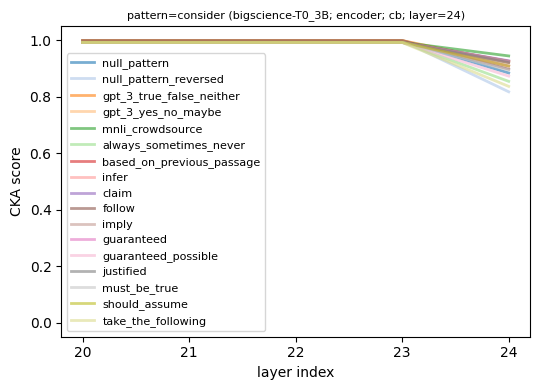

In [20]:
pattern1 = 9

fig, axes = plt.subplots(1, 1, figsize=(5.5, 4), dpi=100)

cmap = matplotlib.cm.get_cmap('tab20')
colors = cmap.colors

for idx, pattern2 in enumerate(range(len(df))[:]):
    if pattern2 == pattern1:
        continue
    pattern_sim = []

    layers = []
    for layer in list(cka_scores_layers.keys())[-5:]:
        layers.append(layer.split('-')[-1])
        cka_score = cka_scores_layers[layer][pattern1, pattern2]
        pattern_sim.append(cka_score)
    
    axes.plot(pattern_sim, linewidth=2.0, alpha=0.6, color=colors[idx], label=f"{df.iloc[pattern2]['name']}")

axes.set_ylim(-0.05, 1.05)
axes.set_xticks(np.arange(len(pattern_sim)))
axes.set_xticklabels(layers)
axes.set_xlabel("layer index")
axes.set_ylabel("CKA score")

axes.set_title(f"pattern={df.iloc[pattern1]['name']} ({model}; {module}; {task}; layer={layer.split('-')[-1]})", fontsize=8)

axes.legend(loc='best', fontsize=8)
# Put a legend to the right of the current axis
# axes.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), fancybox=True, shadow=False, fontsize=8)

plt.tight_layout();